In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import requests
import tensorflow as tf


In [ ]:
# Load and preprocess the data
data = pd.read_csv('/content/drive/MyDrive/clickbit datasets/Features_For_Traditional_ML_Techniques.csv')
data = data.drop(columns=['Unnamed: 0', 'majority_target', 'statement', 'embeddings'])

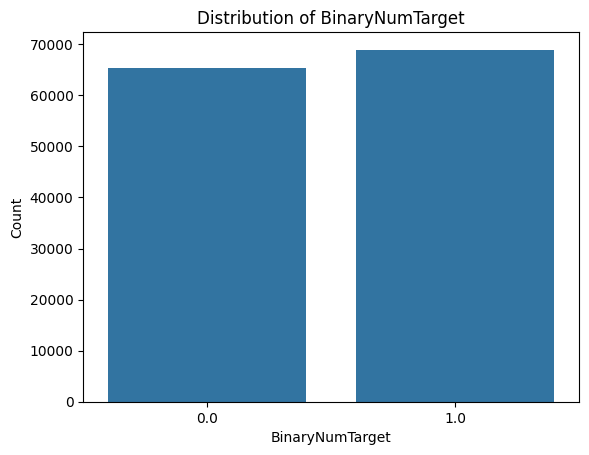

In [ ]:
# Plot target variable distribution
sns.countplot(x='BinaryNumTarget', data=data)
plt.xlabel('BinaryNumTarget')
plt.ylabel('Count')
plt.title('Distribution of BinaryNumTarget')
plt.show()

In [ ]:
data['BinaryNumTarget'].value_counts()

,count
BinaryNumTarget,
1.0,68930
0.0,65268


In [ ]:
# Separate majority and minority classes
df_majority = data[data['BinaryNumTarget'] == 0]
df_minority = data[data['BinaryNumTarget'] == 1]

In [ ]:
# If the minority class is larger than the majority class, swap them
if len(df_minority) > len(df_majority):
    df_majority, df_minority = df_minority, df_majority

In [ ]:
from sklearn.utils import resample


In [ ]:
# Undersample the majority class to the size of the minority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,  # sample without replacement
                                   n_samples=min(len(df_majority), len(df_minority)),  # use the size of the smaller class
                                   random_state=42)  # reproducible results

In [ ]:
# Combine the downsampled majority class with the minority class
data = pd.concat([df_majority_downsampled, df_minority])

In [ ]:
# Shuffle the dataset to mix the majority and minority classes
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

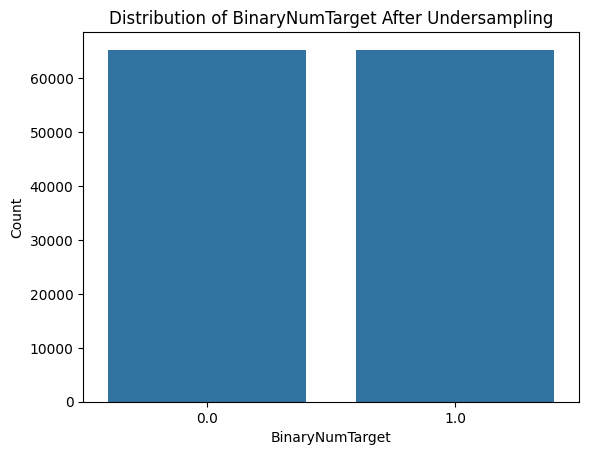

BinaryNumTarget
1.0    65268
0.0    65268
Name: count, dtype: int64


In [ ]:
# Plot the new target variable distribution
sns.countplot(x='BinaryNumTarget', data=data)
plt.xlabel('BinaryNumTarget')
plt.ylabel('Count')
plt.title('Distribution of BinaryNumTarget After Undersampling')
plt.show()

# Check the distribution
print(data['BinaryNumTarget'].value_counts())

In [ ]:
# Prepare tweet data for model
max_words = 1000  # Max number of words to keep in Tokenizer
max_seq_length = 100  # Max sequence length for padding


In [ ]:
import re

def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = text.lower().strip()  # Convert to lowercase and strip leading/trailing spaces
    return text

data['tweet'] = data['tweet'].apply(clean_text)


In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['tweet'])
sequences = tokenizer.texts_to_sequences(data['tweet'])
word_index = tokenizer.word_index

tweet_data = pad_sequences(sequences, maxlen=max_seq_length)

In [ ]:
# Target variable
target = data['BinaryNumTarget'].values

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(tweet_data, target, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Attention

In [ ]:
# RNN Model Architecture
# Input layer
text_input = Input(shape=(max_seq_length,))

# Embedding layer
embedding_layer = Embedding(max_words, 100)(text_input)

# Bidirectional LSTM layers with return sequences for attention
bi_lstm_layer_1 = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
dropout_1 = Dropout(0.4)(bi_lstm_layer_1)

bi_lstm_layer_2 = Bidirectional(LSTM(64, return_sequences=True))(dropout_1)
dropout_2 = Dropout(0.4)(bi_lstm_layer_2)

# Attention mechanism
attention_output = Attention()([bi_lstm_layer_2, bi_lstm_layer_2])

# LSTM layer to process the attention output
lstm_layer = LSTM(64, return_sequences=False)(attention_output)
dropout_3 = Dropout(0.4)(lstm_layer)

# Dense layers
dense_layer_1 = Dense(128, activation='relu')(dropout_3)
dropout_4 = Dropout(0.4)(dense_layer_1)

dense_layer_2 = Dense(64, activation='relu')(dropout_4)
dropout_5 = Dropout(0.4)(dense_layer_2)

# Output layer (binary classification)
output_layer = Dense(1, activation='sigmoid')(dropout_5)


In [ ]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001)

In [ ]:
model = Model(inputs=text_input, outputs=output_layer)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Model Training
callbacks = [EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)]
history = model.fit(X_train, y_train, epochs=70, batch_size=32,
                    validation_split=0.2, callbacks=callbacks)


Epoch 1/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 80s 29ms/step - accuracy: 0.7040 - loss: 0.4961 - val_accuracy: 0.9208 - val_loss: 0.2098
Epoch 2/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 75s 29ms/step - accuracy: 0.9239 - loss: 0.2085 - val_accuracy: 0.9259 - val_loss: 0.1926
Epoch 3/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 74s 28ms/step - accuracy: 0.9295 - loss: 0.1962 - val_accuracy: 0.9296 - val_loss: 0.1860
Epoch 4/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9342 - loss: 0.1810 - val_accuracy: 0.9268 - val_loss: 0.1858
Epoch 5/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 81s 28ms/step - accuracy: 0.9353 - loss: 0.1756 - val_accuracy: 0.9314 - val_loss: 0.1807
Epoch 6/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9373 - loss: 0.1653 - val_accuracy: 0.9314 - val_loss: 0.1779
Epoch 7/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 83s 29ms/step - accuracy: 0.9402 - loss: 0.1570 - val_accuracy: 0.9358 - val_loss: 0.1748
Epoch 8/70
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 80s 28ms/step - accuracy: 0.9440 -

In [ ]:
# Print validation accuracy for each epoch
val_accuracy = history.history['val_accuracy']
print("Validation Accuracy for each epoch:")
for epoch, accuracy in enumerate(val_accuracy, 1):
    print(f"Epoch {epoch}: {accuracy:.4f}")

# Print final validation accuracy
final_val_accuracy = val_accuracy[-1]
print(f'Final Validation Accuracy: {final_val_accuracy:.4f}')

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Validation Accuracy for each epoch:
Epoch 1: 0.9208
Epoch 2: 0.9259
Epoch 3: 0.9296
Epoch 4: 0.9268
Epoch 5: 0.9314
Epoch 6: 0.9314
Epoch 7: 0.9358
Epoch 8: 0.9356
Epoch 9: 0.9357
Epoch 10: 0.9391
Epoch 11: 0.9392
Epoch 12: 0.9365
Epoch 13: 0.9379
Epoch 14: 0.9398
Final Validation Accuracy: 0.9398
816/816 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9414 - loss: 0.1611
Test Accuracy: 94.04%


In [ ]:
# Define the function to get relevant news URLs
def get_relevant_urls(tweet_text):
    api_key = '06cba0dcd3d84dc3bc34aac90e62ba89'  # Replace with your actual NewsAPI.org API key
    url = f'https://newsapi.org/v2/everything?q={tweet_text}&sortBy=relevancy&apiKey={api_key}'

    response = requests.get(url)
    response_data = response.json()

    try:
        articles = response_data['articles']
    except KeyError:
        print("Error: The 'articles' key was not found in the API response.")
        return []

    urls = [article.get('url', '') for article in articles]
    return urls

In [ ]:
# Example for new texts
new_texts = [
  "Sri Lanka faces a crucial challenge as they head into the second Test against England on Thursday at Lord’s, a venue that has often served as an unlikely home away from home for the visiting side."
 ]

In [ ]:
# Preprocess the new texts
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_data = pad_sequences(new_sequences, maxlen=max_seq_length)

In [ ]:
# Get predictions and news URLs
new_predictions = model.predict(new_data)
predicted_classes = (new_predictions > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


In [ ]:
for text, prediction in zip(new_texts, predicted_classes):
    print(f"Tweet: {text}")
    print(f"Prediction: {'Positive' if prediction == 1 else 'Negative'}")
    urls = get_relevant_urls(text)
    print(f"Relevant News URLs: {urls}")
    print()

Tweet: Sri Lanka faces a crucial challenge as they head into the second Test against England on Thursday at Lord’s, a venue that has often served as an unlikely home away from home for the visiting side.
Prediction: Negative
Relevant News URLs: []



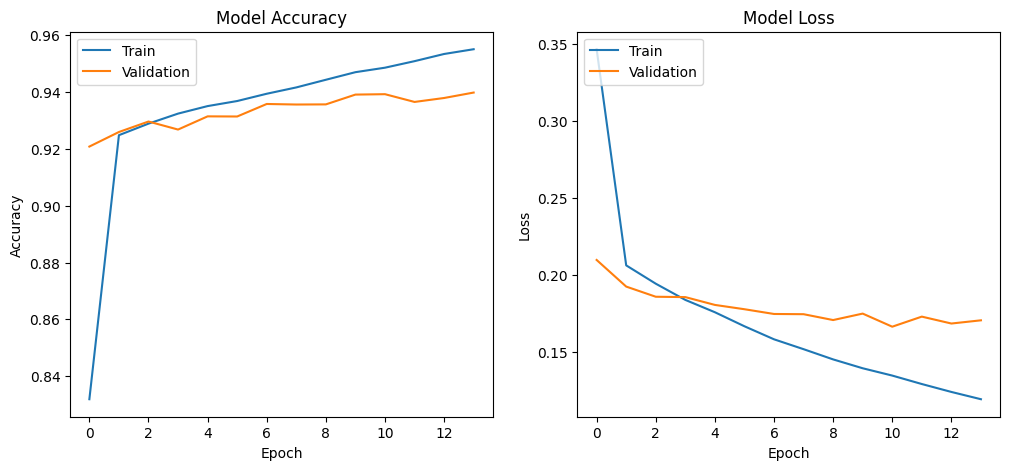

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

816/816 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step


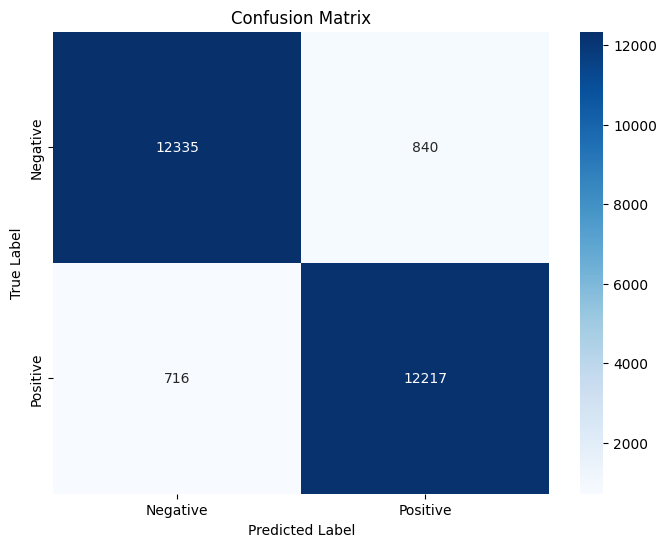

              precision    recall  f1-score   support

    Negative       0.95      0.94      0.94     13175
    Positive       0.94      0.94      0.94     12933

    accuracy                           0.94     26108
   macro avg       0.94      0.94      0.94     26108
weighted avg       0.94      0.94      0.94     26108



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Make predictions on the test set
y_pred_prob = model.predict(X_test)

# Step 2: Convert probabilities to binary labels
y_pred = (y_pred_prob > 0.5).astype(int)

# Step 3: Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Optional: Print a classification report for detailed metrics
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


In [ ]:
model.save('verity_function3.h5')


Re training process

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model2 = load_model('/content/verity_function3.h5')


In [ ]:
# Load dataset from a local CSV file
custom_data = pd.read_csv('/content/drive/MyDrive/clickbit datasets/Function3_data.csv')

# Display the first few rows to check if it's loaded correctly
custom_data.head()

,heading,content,label,Word count,Max word length,Min word length,Average word length,present_verbs,past_verbs,adjectives,...,PERSON,ORDINAL,TIME,NORP,FAC,WORK_OF_ART,MONEY,PERCENT,LAW,LANGUAGE
0,New largest dinosaur species found in Australi...,Scientists in Australia lack declassify a old ...,1,379.0,16.0,1.0,5.242744,47.0,0.0,40.0,...,5.405405,2.702703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SAITM issue: President to discuss with stakeho...,President Maithripala Sirisena disinherit summ...,1,117.0,20.0,1.0,5.683761,22.0,0.0,6.0,...,25.000000,NaN,12.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Intern’l responsibilities crucial for developm...,Norwegian Prime Minister Erna Solberg said tod...,1,251.0,16.0,1.0,5.840637,38.0,0.0,27.0,...,25.000000,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,Five remanded over assault on Sri Lankan HC,"Five people , who differ arrested for allegedl...",1,126.0,14.0,1.0,5.214286,17.0,0.0,6.0,...,17.391304,NaN,4.347826,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Banners with LTTE chief's pic land duo in jail,Two nonmember of a fringe Tamil nationalist pa...,1,169.0,12.0,1.0,5.313609,23.0,0.0,11.0,...,25.000000,3.571429,NaN,3.571429,3.571429,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Ensure 'text' column contains strings
custom_data['content'] = custom_data['content'].astype(str)

# Replace NaN or missing values with empty strings
custom_data['content'] = custom_data['content'].fillna('')

In [ ]:
# Clean and preprocess the data
def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = text.lower().strip()  # Convert to lowercase and strip leading/trailing spaces
    return text

custom_data['content'] = custom_data['content'].apply(clean_text)


In [ ]:
# Separate data into '0' and '1' classes
data_00 = custom_data[custom_data['label'] == 0]
data_11 = custom_data[custom_data['label'] == 1]

In [ ]:
from sklearn.utils import resample


In [ ]:
#Randomly oversample the minority class to match the majority class
data_11_oversampled = resample(data_11,
                             replace=True,    # Sample with replacement
                            n_samples=len(data_00),  # Match number of majority class
                           random_state=42)  # For reproducibility

#Combine the majority class with the oversampled minority class
data_balanced1 = pd.concat([data_00, data_11_oversampled])

In [ ]:
# Shuffle the combined dataset to mix the samples
data_balanced1 = data_balanced1.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target
x_balanced1 = data_balanced1.drop(columns=['label'])
y_balanced1 = data_balanced1['label']

In [ ]:
num_rows = x_balanced1.shape[0]
print(f'Number of rows: {num_rows}')

Number of rows: 1712


In [ ]:
data_balanced1['label'].value_counts()

,count
label,
0,856
1,856


In [ ]:
# Tokenizer and padding
tokenizer1 = Tokenizer(num_words=max_words)
tokenizer1.fit_on_texts(data_balanced1['content'])
sequences1 = tokenizer1.texts_to_sequences(data_balanced1['content'])
tweet_data1 = pad_sequences(sequences1, maxlen=max_seq_length)

# Target variable
target1 = y_balanced1.values

In [ ]:
import pickle
with open('function3_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [ ]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(tweet_data1, target1, test_size=0.2, random_state=42)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model (ensure it uses the same configuration as before)
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])  # Change to a less suitable loss function

# Train the model with custom data
callbacks = [EarlyStopping(patience=2, monitor='val_loss', restore_best_weights=True)]
history2 = model2.fit(X_train1, y_train1, epochs=10, batch_size=64,
                    validation_split=0.2, callbacks=callbacks)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9883 - loss: 0.0100 - val_accuracy: 0.9854 - val_loss: 0.0135
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9807 - loss: 0.0157 - val_accuracy: 0.9781 - val_loss: 0.0198
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9855 - loss: 0.0116 - val_accuracy: 0.9526 - val_loss: 0.0396


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model
loss, accuracy = model2.evaluate(X_test1, y_test1)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9708 - loss: 0.0257
Test Accuracy: 97.08%


In [ ]:
# Make predictions on the test set
y_pred_prob1 = model2.predict(X_test1)
y_pred1 = (y_pred_prob1 > 0.5).astype(int)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test1, y_pred1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


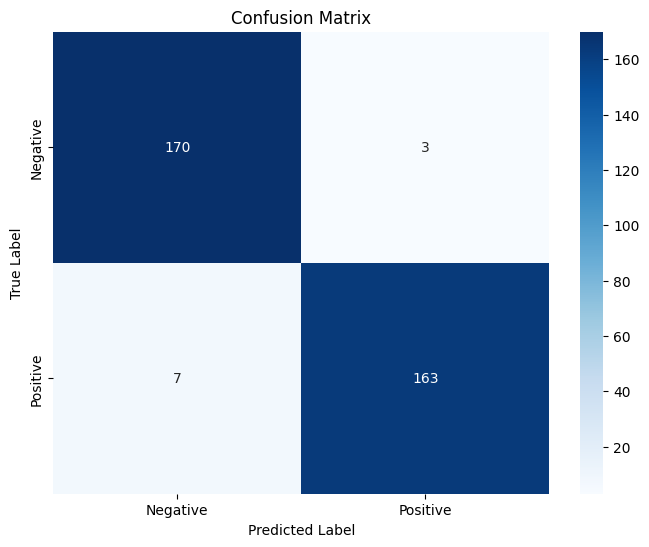

              precision    recall  f1-score   support

    Negative       0.96      0.98      0.97       173
    Positive       0.98      0.96      0.97       170

    accuracy                           0.97       343
   macro avg       0.97      0.97      0.97       343
weighted avg       0.97      0.97      0.97       343



In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report
print(classification_report(y_test1, y_pred1, target_names=['Negative', 'Positive']))


In [ ]:
# Save the retrained model
model2.save('verity_function3_retrained.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved retrained model
model_retrained = load_model('verity_function3_retrained.h5')


In [ ]:
# Example new news article (replace this with the actual text)
new_article = "මොරගහකන්ද ජලාශයට ආසන්නව ගිරිතලේ - ඇළහැර අභයභූමියේ සැරිසරමින් සිටි ඇත් පැටවකු දඩයක්කරුවෙකුගේ වෙඩි පහර කිහිපයකින් මියගොස් ඇතැයි ඇළහැර වනජීවී කාර්යාලය සඳහන් කරයි"
new_article2 = "සිදුව අමන්දොළුව ප්‍රදේශයේ බෝඩිං කාමරයක සිටි කාන්තාවක තියුණු ආයුධයකින් පහරදී ඝාතනය කර ඇතැයි සීදූව පොලිසිය පවසයි."

In [ ]:
# Clean the text using the same function
def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = text.lower().strip()  # Convert to lowercase and strip leading/trailing spaces
    return text

cleaned_article = clean_text(new_article2)

# Tokenize and pad the text using the tokenizer you fitted earlier
# Load the tokenizer if you saved it earlier
with open('function3_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Convert text to sequences
article_sequence = tokenizer.texts_to_sequences([cleaned_article])

# Pad the sequence to match the training input shape
padded_article = pad_sequences(article_sequence, maxlen=max_seq_length)


In [ ]:
# Make prediction
prediction_prob = model_retrained.predict(padded_article)

# Convert probability to a binary prediction (1 or 0)
prediction = (prediction_prob > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


In [ ]:
print(prediction_prob)

[[0.09090646]]


In [ ]:
# Print the result
if prediction[0][0] == 1:
    print("The news is likely true (Positive).")
else:
    print("The news is likely false (Negative).")


The news is likely false (Negative).
